In [82]:
#Reference https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import h5py
#import matplotlib.pyplot as plt
#import matplotlib.pylab as plb
import numpy as np
#import os
import os
# To disable all logging output from TensorFlow
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import cv2
import random

import custom_batch_generator_hpf5

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
#import tensorflow_addons as tfa

In [4]:
batch_size = 4

ValImgPath = "/home/catz/ocrWork/ValidationImages2.h5"
ValMskPath = "/home/catz/ocrWork/ValidationMasks2.h5"
ValmDG = custom_batch_generator_hpf5.myDataGenerator(ValImgPath, ValMskPath, batch_size)

TrainImgPath = "/home/catz/ocrWork/TrainImages.h5"
TrainMskPath = "/home/catz/ocrWork/TrainMasks.h5"
TrainmDG = custom_batch_generator_hpf5.myDataGenerator(TrainImgPath, TrainMskPath, batch_size)

print("number of batchs: {}".format(len(TrainmDG)))
print("number of batchs: {}".format(len(ValmDG)))

number of batchs: 5000
number of batchs: 500


In [5]:
N_CLASSES = 4

In [6]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (256, 512,1)

# If you want to know more about why we are using `he_normal`:
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excellent fastai course:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'

# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    #pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = np.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    #pred_mask = tf.expand_dims(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis = 2)
    return pred_mask

In [9]:
def display_sample( display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    #plt.savefig('prediction-epoch-{epochs:02d}.png')

In [10]:
def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        Images, Masks = TrainmDG[6]
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = Images[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference[0])
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        print("I:", type(Images[0]), Images[0].shape, Images[0].dtype)
        print("M:",type(Masks[0]), Masks[0].shape, Masks[0].dtype)
        print("P:", type( pred_mask), pred_mask.shape, pred_mask.dtype)
        display_sample([Images[0], Masks[0], pred_mask])

I: <class 'numpy.ndarray'> (256, 512, 1) float64
M: <class 'numpy.ndarray'> (256, 512, 1) float64
P: <class 'numpy.ndarray'> (256, 512, 1) int64


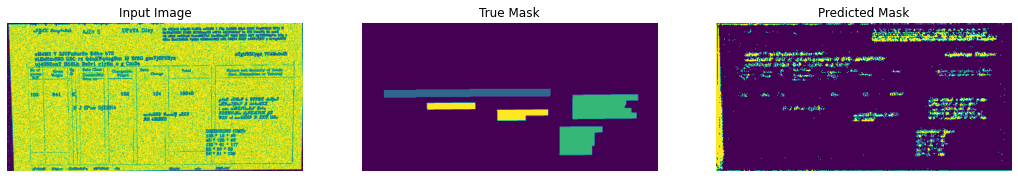

In [11]:
show_predictions()

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epochs+1))

In [13]:
EPOCHS = 80

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='epoch', write_graph=True, profile_batch=0)

filepath = "saved-model-{epoch:02d}.hdf5"

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    #tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
]

In [14]:
model = tf.keras.Model(inputs = inputs, outputs = output)

# here I'm using a new optimizer: https://arxiv.org/abs/1908.03265
#optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=Adam(learning_rate=0.0001), loss = loss,
                  metrics=['accuracy'])

I: <class 'numpy.ndarray'> (256, 512, 1) float64
M: <class 'numpy.ndarray'> (256, 512, 1) float64
P: <class 'numpy.ndarray'> (256, 512, 1) int64


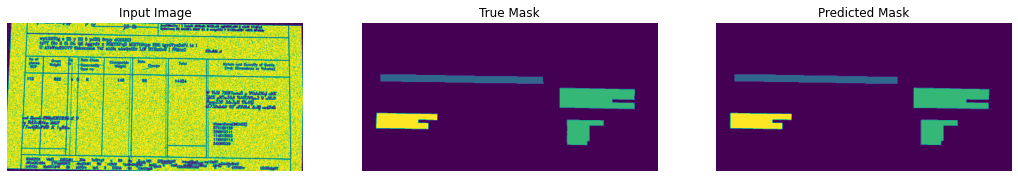


Sample Prediction after epoch 8

5000/5000 [==============================] - 3441s 688ms/step - loss: 0.0067 - acc: 0.9974
Epoch 9/80
 424/5000 [=>............................] - ETA: 52:34 - loss: 0.0063 - acc: 0.9975

KeyboardInterrupt: 

In [15]:
history1 = model.fit(x=TrainmDG,
                            steps_per_epoch= len(TrainmDG),
                            epochs = 80,
                            callbacks = callbacks, verbose=1)

In [26]:
def show_predictions_2(img,dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        img = np.expand_dims(img, axis = 2)
        #Images, Masks = TrainmDG[6]
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = img[tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference[0])
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        print("I:", type(img), img.shape, img.dtype)
        #print("M:",type(Masks[0]), Masks[0].shape, Masks[0].dtype)
        print("P:", type( pred_mask), pred_mask.shape, pred_mask.dtype)
        display_sample([img, pred_mask])

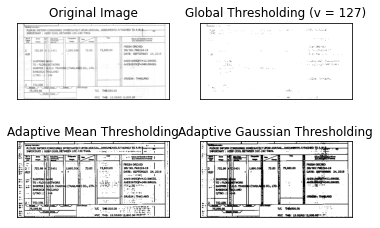

In [55]:
img = cv2.imread("/home/catz/Pictures/test03.png",0)

#img = cv2.medianBlur(img,3)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,1111,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
# img/255.0
#plt.imshow(sample)
#print(sample.dtype, sample.shape)

I: <class 'numpy.ndarray'> (256, 512, 1) float64
P: <class 'numpy.ndarray'> (256, 512, 1) int64


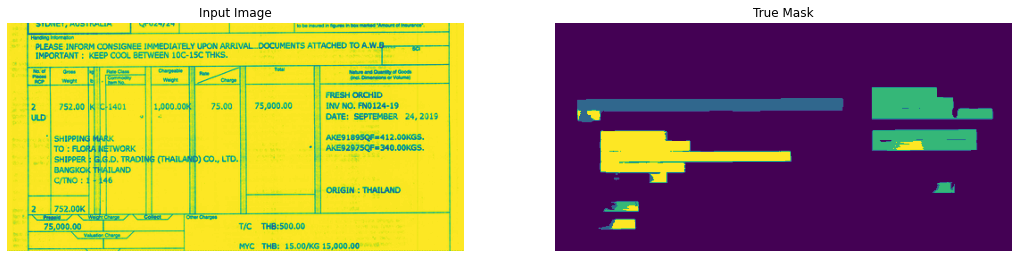

In [56]:
sample = img
sample = sample/255.0
show_predictions_2(sample)

In [60]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append(img)
    return images

In [80]:
testfolder = "/home/catz/Pictures/testfolder2"

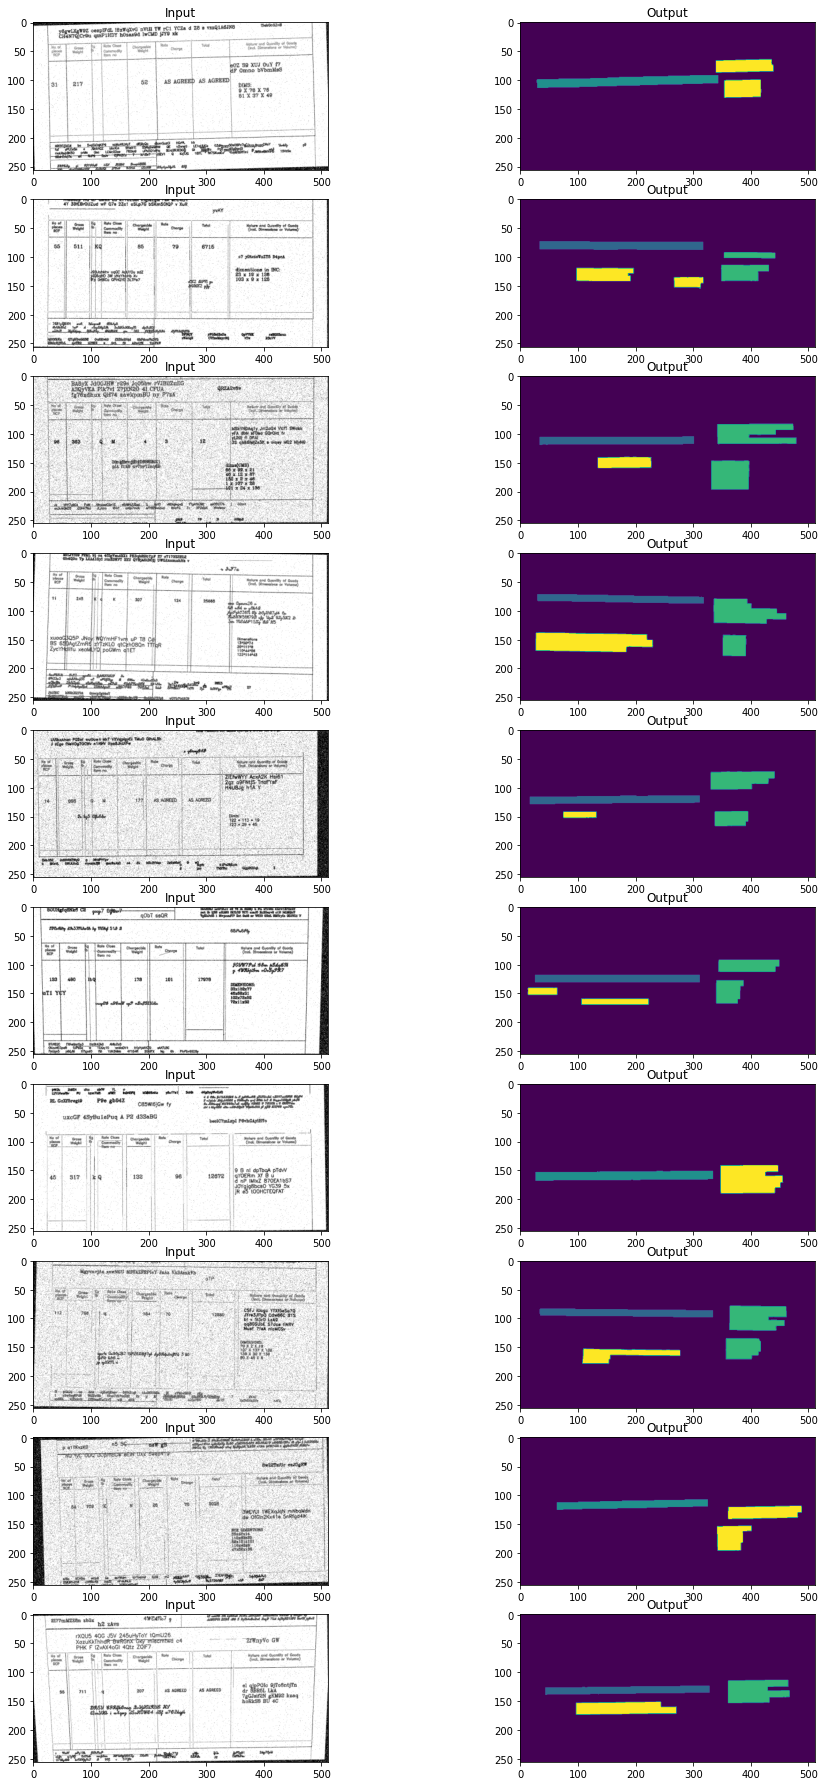

In [81]:
import matplotlib.cm as cm
testImages = load_images_from_folder(testfolder)
#print(len)
predictions = []
imgresized = []
for img in testImages:
    img = cv2.resize(img, (512,256), interpolation = cv2.INTER_AREA)
    imgresized.append(img)
    img = img/255.0
    
    img = np.expand_dims(img, axis = 2)
    #Images, Masks = TrainmDG[6]
    # The model is expecting a tensor of the size
    # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
    # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
    # and we want only 1 inference to be faster
    # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
    one_img_batch = img[tf.newaxis, ...]
    # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
    inference = model.predict(one_img_batch)
    # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
    predMask = create_mask(inference[0])
    predMask = np.squeeze(predMask, axis=2)
    predictions.append(predMask)
    # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]

# Display processed images
fig=plt.figure(figsize=(16,32))
row = len(testImages)
col = 2
for i in range(len(testImages)):
    fig.add_subplot(row, col, i*2+1)
    plt.imshow(imgresized[i],cmap=cm.gray)
    plt.title("Input")
    fig.add_subplot(row, col, i*2+2)
    plt.imshow(predictions[i])
    plt.title("Output")
